In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.chdir("..")

# import sys
# sys.path.append("./vrevals")

import re
import ast
import json
import numpy as np
import pandas as pd
import yaml
import time
import glob

import matplotlib.pyplot as plt

from collections import Counter
from src.utils.math_equivalence import is_math_equiv, extract_boxed_answer
from src.utils.pass_k_utils import estimate_pass_at_k

In [2]:
from transformers import AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
class Args:
    dataset_name = "gsm8k"
    # dataset_name = "aime"
    split = "test"
    subset_num = None
    step_by_step_prompt = True
    n_threads = 1
args = Args()
# job_dir = f"runs/{args.dataset_name}.qwen2.5-0.5b-mutual_metaninstruct1"

# root_dir = "/home/nlp/hnn5071/vreval_runs"
root_dir = "runs"
# job_dir = f"runs/{args.dataset_name}.qwen2.5-0.5b-metaninstruct1"
job_dir = f"{root_dir}/{args.dataset_name}.evolm-1b-exclusive_styles"
# job_dir = f"{root_dir}/{args.dataset_name}.evolm-1b-mutual_styles"


sampler_config_dir = f'{job_dir}/sft_ep10.prefix/sample_1'
prompt_csv_path = f'{job_dir}/{args.split}.prompts.csv'
print(sampler_config_dir)

runs/gsm8k.evolm-1b-exclusive_styles/sft_ep10.prefix/sample_1


In [12]:
all_generation_csv = glob.glob(f"{sampler_config_dir}/{args.split}.generations*.csv")

In [13]:
all_generation_df = []
for csv_path in all_generation_csv:
    epoch_match = re.search(r'ep(\d+)', csv_path)
    if epoch_match:
        epoch_num = int(epoch_match.group(1))
    else:
        epoch_num = None
    temp_df = pd.read_csv(csv_path)
    temp_df['epoch'] = epoch_num
    all_generation_df.append(temp_df)

In [14]:
# all_generation_csv = glob.glob(f"{sampler_config_dir}/generations*.csv")
# Concatenate all dataframes in all_generation_df into a single dataframe
generation_df = pd.concat(all_generation_df, ignore_index=True)
def extract_prefix(row):
    # response = row['response']
    # first_token = tokenizer.tokenize(response[:50])[0]

    prefix = ast.literal_eval(row['sampler_config'].strip())['sampler'].get('thinking_prefix', "")
    # print(eval(row['sampler_config'].strip()).get('thinking_prefix', "default"))
    return prefix
generation_df['prefix'] = generation_df.apply(extract_prefix, axis=1)
generation_df['is_code'] = generation_df['response'].apply(lambda x: "llm-code" in str(x))

# generation_df['pred_answer'] = generation_df.response.apply(extract_boxed_answer)
# generation_df['is_valid'] = generation_df.pred_answer.apply(lambda x: len(x) > 0)
# generation_df['is_correct'] = generation_df.apply(lambda row: is_math_equiv(str(row['gt_answer']), str(row['pred_answer'])), axis=1)

In [15]:
generation_df

,question_id,prompt_id,response,pred_answer,gt_answer,sampler_config,epoch,prefix,is_code
0,0,0,'s solve this problem using Python code.\n<llm...,NaN,18,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True
1,0,0,'s solve this problem using Python code.\n<llm...,NaN,18,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True
2,0,0,'s solve this problem using Python code.\n<llm...,NaN,18,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True
3,0,0,'s solve this problem using Python code.\n<llm...,NaN,18,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True
4,0,0,'s solve this problem using Python code.\n<llm...,NaN,18,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True
...,...,...,...,...,...,...,...,...,...
84411,1318,1318,'s solve this problem using Python code.\n<llm...,NaN,14,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True
84412,1318,1318,'s solve this problem using Python code.\n<llm...,NaN,14,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True
84413,1318,1318,'s solve this problem using Python code.\n<llm...,NaN,14,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True
84414,1318,1318,'s solve this problem using Python's sympy lib...,NaN,14,"{'sampler': {'class': 'VLLMSampler', 'model_na...",10,Let,True


In [16]:
global_code_fraction = generation_df['is_code'].values.sum() / generation_df['is_code'].values.shape[0]

In [17]:
grouped_df = generation_df.groupby(['question_id', 'prompt_id', 'gt_answer'])
style_df = grouped_df.is_code.apply(list).reset_index(name='is_code')
style_df['fraction_code'] = style_df['is_code'].apply(lambda x: sum(x)/len(x))
# pred_answers = grouped_df.pred_answer.apply(list).reset_index(name='text')
# # Count the number of unique values in pred_answers for each question
# # pred_answers['text'] = pred_answers['text'].apply(lambda x: list(filter(lambda i: i != '', x)))
# # pred_answers['num_valid_samples'] = pred_answers['text'].apply(len)
# # pred_answers['num_unique_answers'] = pred_answers['text'].apply(lambda x: len(set(x)))
# pred_answers['fraction_correct_pred'] = grouped_df.is_correct.apply(lambda x: sum(x) / len(x)).values

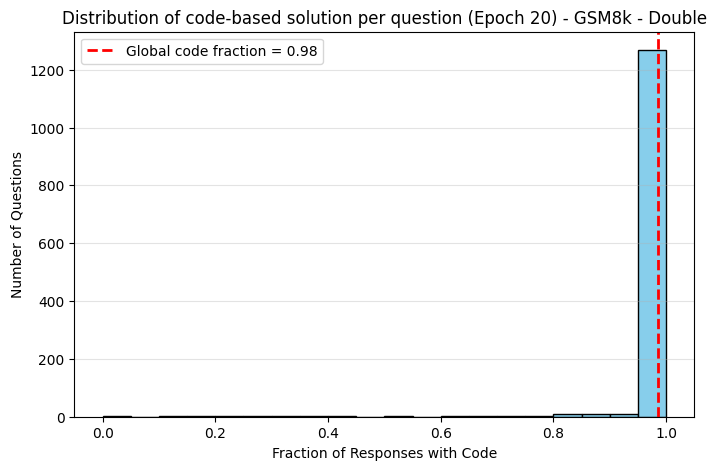

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(style_df.fraction_code.values, bins=20, color="skyblue", edgecolor="black")
plt.axvline(x=global_code_fraction, color='r', linestyle='--', linewidth=2, label=f'Global code fraction = {global_code_fraction:.2f}')
plt.title(r"Distribution of code-based solution per question (Epoch 20) - GSM8k - Double")
plt.xlabel("Fraction of Responses with Code")
plt.ylabel("Number of Questions")
plt.legend()
plt.grid(axis='y', alpha=0.35)